In [1]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  #忽略烦人的警告
tf.logging.set_verbosity(tf.logging.ERROR)   #忽略烦人的警告
print(tf.__version__)
import numpy as np
from sklearn.decomposition import PCA

import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle   #对象存储用

from sklearn import preprocessing

import matplotlib.pyplot as plt
import matplotlib
import math

%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = ['SimHei']

1.13.1


In [2]:
dataroot_1 = "./UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_training-set.csv"
dataroot_2 = "./UNSW-NB15 - CSV Files/a part of training and testing set/UNSW_NB15_testing-set.csv"

In [3]:
labelList = [
    "Normal", "Fuzzers", "Analysis", "Backdoor", "DoS", "Exploits", 
    "Generic", "Reconnaissance", "Shellcode", "Worms"
]
distribution_feature = [    #产生的新特征
    "Normal_Score", "Fuzzers_Score", "Analysis_Score", "Backdoor_Score", "DoS_Score", "Exploits_Score", 
    "Generic_Score", "Reconnaissance_Score", "Shellcode_Score", "Worms_Score"
]
def load_obj(name):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

distributions = {}
distributions['Normal'] = load_obj("normal_Distribution_set")
distributions['Fuzzers'] = load_obj("Fuzzers_Distribution_set")
distributions['Analysis'] = load_obj("Analysis_Distribution_set")
distributions['Backdoor'] = load_obj("Backdoor_Distribution_set")
distributions['DoS'] = load_obj("DoS_Distribution_set")
distributions['Exploits'] = load_obj("Exploits_Distribution_set")
distributions['Generic'] = load_obj("Generic_Distribution_set")
distributions['Reconnaissance'] = load_obj("Reconnaissance_Distribution_set")
distributions['Shellcode'] = load_obj("Shellcode_Distribution_set")
distributions['Worms'] = load_obj("Worms_Distribution_set")


attack_types = 9  #总已知攻击种类
feature_numbers = 23   #用于处理DSM的特征，位列前23的特征


#定义difference weight,取值0~1
def calculate_dw(distribution_1, distribution_2, feature_index):
    count1 = calculate_count(distribution_1, feature_index)
    count2 = calculate_count(distribution_2, feature_index)
    h = 20
    dw = 0
    for i in range(h):
        start = i*5
        end = start + 5
        T1 = distribution_1[str(feature_index)][str(start) + '-' + str(end)]/count1
        T2 = distribution_2[str(feature_index)][str(start) + '-' + str(end)]/count2
        dw += abs(T1 - T2)
    return dw/2
#用于计算分布字典里的实例数
def calculate_count(distribution, feature_index):
    h = 20
    count = 0
    for i in range(h):
        start = i*5
        end = start + 5
        count += distribution[str(feature_index)][str(start) + '-' + str(end)]
    return count
#定义hdw，hybird difference weight  第二个参数为：hdw应用的对应得分公式的对应的哪种字典
def calculate_hdw(feature_index, label):
    base = 0
    for key in distributions:
        if(key == label):
            continue
        dw = calculate_dw(distributions[label], distributions[key], feature_index)
        if(dw > base):
            base = dw
    return base


#计算例子在某种标签上的得分，需要提供对应标签, 这个标签的的分布统计字典
def get_score(example, distributeObj, label):    
    score = 0
    count = calculate_count(distributeObj, 0)  #取哪个特征都一样
    minBase = 1
    baseArr = []
    for i in range(feature_numbers):

        start = int(example[i]/0.05//1)*5   #取200个分组里的分组起始位置
        if(start == 100):     #特殊处理当该属性为1.0时溢出的情况
            start = 95      
        end = start + 5
        dataRange = '{0}-{1}'.format(start, end )
        base = distributeObj[str(i)][dataRange]/count
        if(base != 0 and base < minBase):
            minBase = base
        baseArr.append(base)
        
    for i in range(feature_numbers):
        if(baseArr[i] != 0):
            score += math.log(baseArr[i]) * calculate_hdw(i, label)  / feature_numbers
        else:
            score += math.log(minBase) * calculate_hdw(i, label)  / feature_numbers
            
    return score


def get_score_threshold(dataset_x, dataset_y):
    #10个分数数组，表示在这个label字典下label实例的得分情况
    Scores = {
        "Normal" : [],
        "Fuzzers" : [],
        "Analysis" : [],
        "Backdoor" : [],
        "DoS" : [], 
        "Exploits" : [],
        "Generic" : [],
        "Reconnaissance" : [],
        "Shellcode" : [],
        "Worms" : []
    }
    for i,item in enumerate(dataset_x):
        if(dataset_y.values[i].astype('int') == 0):
            
            Scores["Normal"].append(get_score(item, distributions['Normal'], 'Normal'))
            
        elif(dataset_y.values[i].astype('int') == 1):
            
            Scores["Fuzzers"].append(get_score(item, distributions['Fuzzers'], 'Fuzzers'))
            
        elif(dataset_y.values[i].astype('int') == 2):
            
            Scores["Analysis"].append(get_score(item, distributions['Analysis'], 'Analysis'))
            
        elif(dataset_y.values[i].astype('int') == 3):
            
            Scores["Backdoor"].append(get_score(item, distributions['Backdoor'], 'Backdoor'))
            
        elif(dataset_y.values[i].astype('int') == 4):
            
            Scores["DoS"].append(get_score(item, distributions['DoS'], 'DoS'))
                        
        elif(dataset_y.values[i].astype('int') == 5):
            
            Scores["Exploits"].append(get_score(item, distributions['Exploits'], 'Exploits'))
            
        elif(dataset_y.values[i].astype('int') == 6):
            
            Scores["Generic"].append(get_score(item, distributions['Generic'], 'Generic'))
            
        elif(dataset_y.values[i].astype('int') == 7):
            
            Scores["Reconnaissance"].append(get_score(item, distributions['Reconnaissance'], 'Reconnaissance'))
            
        elif(dataset_y.values[i].astype('int') == 8):
            
            Scores["Shellcode"].append(get_score(item, distributions['Shellcode'], 'Shellcode')) 
            
        elif(dataset_y.values[i].astype('int') == 9):
            
            Scores["Worms"].append(get_score(item, distributions['Worms'], 'Worms'))
            
    thresholds = []
    
    for item in Scores.values():
        item.sort()
        thresholds.append(item[len(item)//10])    #取”将样例分成1：9“的threshold
    return thresholds

def sigmoid(x):
    # TODO: Implement sigmoid function
    return 1/(1 + np.exp(-x))

def get_Full_Scores(dataset_x, dataset_y): 
    Full_Scores = {
        "Normal" : {
            "Normal" : [], 
            "Fuzzers" : [], 
            "Analysis" : [], 
            "Backdoor" : [], 
            "DoS" : [],             
            "Exploits" : [], 
            "Generic" : [], 
            "Reconnaissance" : [], 
            "Shellcode" : [], 
            "Worms" : [] 
            
        },
        "Fuzzers" : {
            "Normal" : [], 
            "Fuzzers" : [], 
            "Analysis" : [], 
            "Backdoor" : [], 
            "DoS" : [],             
            "Exploits" : [], 
            "Generic" : [], 
            "Reconnaissance" : [], 
            "Shellcode" : [], 
            "Worms" : [] 
        },
        "Analysis" : {
            "Normal" : [], 
            "Fuzzers" : [], 
            "Analysis" : [], 
            "Backdoor" : [], 
            "DoS" : [],             
            "Exploits" : [], 
            "Generic" : [], 
            "Reconnaissance" : [], 
            "Shellcode" : [], 
            "Worms" : [] 
        },
        "Backdoor" : {
            "Normal" : [], 
            "Fuzzers" : [], 
            "Analysis" : [], 
            "Backdoor" : [], 
            "DoS" : [],             
            "Exploits" : [], 
            "Generic" : [], 
            "Reconnaissance" : [], 
            "Shellcode" : [], 
            "Worms" : [] 
        },
        "DoS" : {
            "Normal" : [], 
            "Fuzzers" : [], 
            "Analysis" : [], 
            "Backdoor" : [], 
            "DoS" : [],             
            "Exploits" : [], 
            "Generic" : [], 
            "Reconnaissance" : [], 
            "Shellcode" : [], 
            "Worms" : [] 
        },        
        "Exploits" : {
            "Normal" : [], 
            "Fuzzers" : [], 
            "Analysis" : [], 
            "Backdoor" : [], 
            "DoS" : [],             
            "Exploits" : [], 
            "Generic" : [], 
            "Reconnaissance" : [], 
            "Shellcode" : [], 
            "Worms" : [] 
        },    
        "Generic" : {
            "Normal" : [], 
            "Fuzzers" : [], 
            "Analysis" : [], 
            "Backdoor" : [], 
            "DoS" : [],             
            "Exploits" : [], 
            "Generic" : [], 
            "Reconnaissance" : [], 
            "Shellcode" : [], 
            "Worms" : [] 
        },
        "Reconnaissance" : {
            "Normal" : [], 
            "Fuzzers" : [], 
            "Analysis" : [], 
            "Backdoor" : [], 
            "DoS" : [],             
            "Exploits" : [], 
            "Generic" : [], 
            "Reconnaissance" : [], 
            "Shellcode" : [], 
            "Worms" : [] 
        },
        "Shellcode" : {
            "Normal" : [], 
            "Fuzzers" : [], 
            "Analysis" : [], 
            "Backdoor" : [], 
            "DoS" : [],             
            "Exploits" : [], 
            "Generic" : [], 
            "Reconnaissance" : [], 
            "Shellcode" : [], 
            "Worms" : [] 
        },
        "Worms" : {
            "Normal" : [], 
            "Fuzzers" : [], 
            "Analysis" : [], 
            "Backdoor" : [], 
            "DoS" : [],             
            "Exploits" : [], 
            "Generic" : [], 
            "Reconnaissance" : [], 
            "Shellcode" : [], 
            "Worms" : [] 
        }
    }
    for i,item in enumerate(dataset_x):
        itemLabel = labelList[int(dataset_y.values[i])]
        Full_Scores["Normal"][itemLabel].append(get_score(item, distributions["Normal"], "Normal")) 
        Full_Scores["Fuzzers"][itemLabel].append(get_score(item, distributions["Fuzzers"], "Fuzzers"))
        Full_Scores["Analysis"][itemLabel].append(get_score(item, distributions["Analysis"], "Analysis"))
        Full_Scores["Backdoor"][itemLabel].append(get_score(item, distributions["Backdoor"], "Backdoor"))
        Full_Scores["DoS"][itemLabel].append(get_score(item, distributions["DoS"], "DoS"))
        Full_Scores["Exploits"][itemLabel].append(get_score(item, distributions["Exploits"], "Exploits")) 
        Full_Scores["Generic"][itemLabel].append(get_score(item, distributions["Generic"], "Generic"))
        Full_Scores["Reconnaissance"][itemLabel].append(get_score(item, distributions["Reconnaissance"], "Reconnaissance"))
        Full_Scores["Shellcode"][itemLabel].append(get_score(item, distributions["Shellcode"], "Shellcode"))
        Full_Scores["Worms"][itemLabel].append(get_score(item, distributions["Worms"], "Worms"))
    return Full_Scores
    


In [4]:
#选择需要进行创建字典的特征。实际有
def feature_selection(dataset):
    return dataset[[
        'dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 
        'sloss', 'sinpkt', 'sjit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 
        'ct_srv_src', 'ct_state_ttl', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 
        'ct_dst_src_ltm', 'ct_srv_dst', 'attack_cat'
    ]]
def split_valid_from_train(train_dataset, valid_size):
    # Method 1
    train_dataset, valid_dataset, _, _ = train_test_split(train_dataset, train_dataset['attack_cat'], test_size=valid_size, random_state=None)
    # pandas中先重置index再打乱train. 否则只会调整各个行的顺序，而不会改变pandas的index
    # 重置
    train_dataset = train_dataset.reset_index(drop=True)
    # 打乱
    indexMask = np.arange(len(train_dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    train_dataset = train_dataset.iloc[indexMask]

    return train_dataset, valid_dataset

def shuffle(dataset):  
    # 打乱
    indexMask = np.arange(len(dataset))
    for i in range(10):
        np.random.shuffle(indexMask)
    dataset = dataset.iloc[indexMask]
    dataset = dataset.reset_index(drop=True)

    return dataset 


def filter_useless_feature(dataset):
    dataset = dataset.drop(['label'], axis=1)    #两个特征没用
    dataset = dataset.drop(['id'], axis=1)
    return dataset

def filter_labels(dataset):
    dataset['attack_cat'] = dataset['attack_cat'].apply(labels_map)
    return dataset

def labels_map(label):
    if(type(label) == int):      #已是数字，无需处理
        return label
    
    if label == 'Normal':
        return 0
    if label == 'Fuzzers':
        return 1
    if label == 'Analysis':
        return 2
    if label == 'Backdoor':
        return 3
    if label == 'DoS':
        return 4
    if label == 'Exploits':
        return 5
    if label == 'Generic':
        return 6
    if label == 'Reconnaissance':
        return 7
    if label == 'Shellcode':
        return 8
    if label == 'Worms':
        return 9
    return -1

def labels_separate(dataset):
    y_ = dataset['attack_cat'].astype('int')
    temp = dataset
    temp.drop(['attack_cat'], axis=1, inplace=True)
    x_ = temp.values
    return x_, y_

In [5]:
#归一化整个数据集，注意要存储归一化的参数x_avg,x_max,x_min以便后面真实环境预处理需要
def normalization(dataset):
    epsilon = 0.0001   #防止除数为0
    dataset = dataset.astype('float')
    target_features = [
        'dur', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 
        'sloss', 'sinpkt', 'sjit', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 
        'ct_srv_src', 'ct_state_ttl', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 
        'ct_dst_src_ltm', 'ct_srv_dst'
    ]
    
    norm_params = pd.DataFrame(np.zeros([3, len(target_features)]), columns=target_features)  #存储归一化参数
    
    for feature in dataset.columns.values.tolist():    #对列（特征名）进行遍历
        if feature in target_features:
            x = dataset[feature]
            x_avg = dataset[feature].mean()
            x_max = np.max(dataset[feature])
            x_min = np.min(dataset[feature])

            norm_params[feature] = [x_avg, x_max, x_min]
            dataset[feature] = (x - x_min) / (x_max - x_min + epsilon)
            #dataset = dataset.drop([feature], axis=1)
    return dataset,norm_params
    
def combine_dataset(trainDF, testDF):
    all = pd.concat([trainDF, testDF], axis=0)
    return all, (trainDF.shape[0], testDF.shape[0])

def separate_dataset(comb, num_comb):  
    train_dataset_size , test_dataset_size = num_comb
    trainDF = comb.iloc[:train_dataset_size]
    testDF = comb.iloc[train_dataset_size: (train_dataset_size + test_dataset_size)]
    return trainDF, testDF

   
def data_process_full(trainDF, testDF):
    all, num_comb = combine_dataset(trainDF, testDF)
    all,norm_params = normalization(all)
    trainDF,testDF = separate_dataset(all, num_comb)
    return trainDF,testDF,norm_params

In [6]:
df_train_1 = pd.read_csv(dataroot_1,header=0,low_memory=False)  
df_train_2 = pd.read_csv(dataroot_2,header=0,low_memory=False)  
dataset = df_train_1.append([df_train_2])

In [7]:
dataset = filter_useless_feature(dataset)
dataset = filter_labels(dataset)

In [8]:
normal_df = dataset.loc[dataset['attack_cat'] == 0]
normal_df = normal_df.sample(n=90000,random_state=1, replace=False)
df_normal_train, df_normal_test = split_valid_from_train(normal_df, 0.2)

Fuzzers_df = dataset.loc[dataset['attack_cat'] == 1]
Fuzzers_df = Fuzzers_df.sample(n=5000,random_state=1, replace=False)
df_Fuzzers_train, df_Fuzzers_test = split_valid_from_train(Fuzzers_df, 0.2)

Analysis_df = dataset.loc[dataset['attack_cat'] == 2]
Analysis_df = Analysis_df.sample(n=5000,random_state=1, replace=True)
df_Analysis_train, df_Analysis_test = split_valid_from_train(Analysis_df, 0.2)

Backdoor_df = dataset.loc[dataset['attack_cat'] == 3]
Backdoor_df = Backdoor_df.sample(n=5000,random_state=1, replace=True)
df_Backdoor_train, df_Backdoor_test = split_valid_from_train(Backdoor_df, 0.2)

DoS_df = dataset.loc[dataset['attack_cat'] == 4]
DoS_df = DoS_df.sample(n=5000,random_state=1, replace=False)
df_DoS_train, df_DoS_test = split_valid_from_train(DoS_df, 0.2)

Exploits_df = dataset.loc[dataset['attack_cat'] == 5]
Exploits_df = Exploits_df.sample(n=5000,random_state=1, replace=False)
df_Exploits_train, df_Exploits_test = split_valid_from_train(Exploits_df, 0.2)

Generic_df = dataset.loc[dataset['attack_cat'] == 6]
Generic_df = Generic_df.sample(n=50000,random_state=1, replace=False)
df_Generic_train, df_Generic_test = split_valid_from_train(Generic_df, 0.2)

Reconnaissance_df = dataset.loc[dataset['attack_cat'] == 7]
Reconnaissance_df = Reconnaissance_df.sample(n=5000,random_state=1, replace=False)
df_Reconnaissance_train, df_Reconnaissance_test = split_valid_from_train(Reconnaissance_df, 0.2)

Shellcode_df = dataset.loc[dataset['attack_cat'] == 8]
Shellcode_df = Shellcode_df.sample(n=5000,random_state=1, replace=True)
df_Shellcode_train, df_Shellcode_test = split_valid_from_train(Shellcode_df, 0.2)

Worms_df = dataset.loc[dataset['attack_cat'] == 9]
Worms_df = Worms_df.sample(n=5000,random_state=1, replace=True)
df_Worms_train, df_Worms_test = split_valid_from_train(Worms_df, 0.2)


In [9]:
#整合
df_train = df_normal_train.append([df_Fuzzers_train, df_Analysis_train, df_Backdoor_train, df_DoS_train, df_Exploits_train, df_Generic_train, df_Reconnaissance_train, df_Shellcode_train, df_Worms_train])
df_test = df_normal_test.append([df_Fuzzers_test, df_Analysis_test, df_Backdoor_test, df_DoS_test, df_Exploits_test, df_Generic_test, df_Reconnaissance_test, df_Shellcode_test, df_Worms_test])


In [10]:
#特征选择
df_train = feature_selection(df_train)
df_test = feature_selection(df_test)

In [11]:
#正则化
df_train, df_test, norm_params = data_process_full(
    df_train, df_test
)

In [12]:
#分离标签
df_train_X, df_train_y = labels_separate(df_train)
df_test_X, df_test_y = labels_separate(df_test)

In [13]:
print(df_train.shape)
print(df_train.values[0])

(144000, 23)
[1.74499741e-05 1.82315404e-04 8.21970520e-06 1.21456796e-05
 2.86532935e-03 1.21568580e-01 1.14173183e-01 1.04375772e-04
 3.03280728e-02 0.00000000e+00 1.66638915e-07 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.04878028e-02
 5.93333294e-02 1.61290062e-02 0.00000000e+00 1.72413496e-02
 0.00000000e+00 0.00000000e+00 8.19670787e-02]


In [14]:
thresholds = get_score_threshold(df_train_X, df_train_y)

In [15]:
full_Scores = get_Full_Scores(df_test_X, df_test_y)

In [23]:
from matplotlib import pyplot

def drawSingle(label):
    pyplot.hist(full_Scores[label][label], 20, density=True, histtype='step', color='black', cumulative=True)
    pyplot.xlabel('Scoring')
    pyplot.ylabel('Frequency')
    pyplot.title('Scores of '+label+' samples on '+label+' distribution') 
    plt.savefig("./scores/" + label + "_base/Scores of "+label+" samples on "+label+" distribution.eps",format="eps")
    pyplot.show()
    
def drawComparison(base_label, compare_label):
    pyplot.hist(full_Scores[base_label][base_label], 20, density=True, histtype='step', color='black', cumulative=True)
    pyplot.hist(full_Scores[base_label][compare_label], 20, density=True, histtype='step', cumulative=True)
    pyplot.xlabel('Scoring')
    pyplot.ylabel('Frequency')
    pyplot.title('Scoring comparsion between '+compare_label+' and ' + base_label)
    plt.savefig("./scores/" + base_label + "_base/comparsion between "+compare_label+" and " + base_label + ".eps",format="eps")
    pyplot.show()


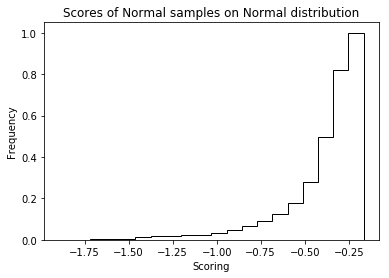

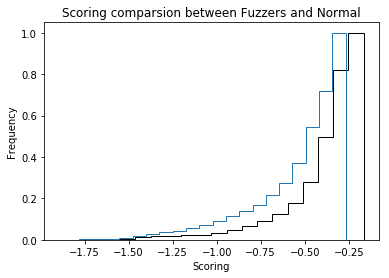

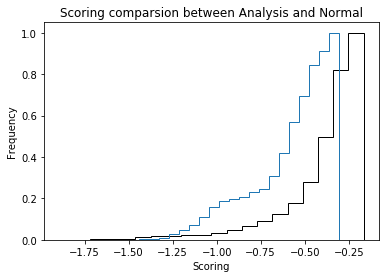

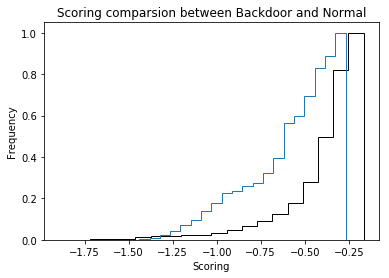

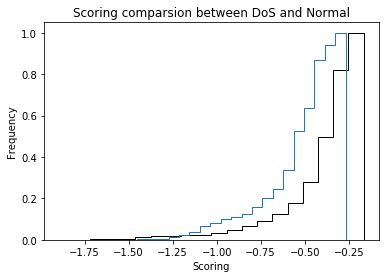

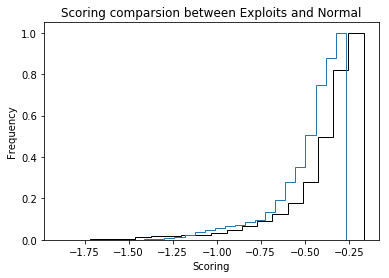

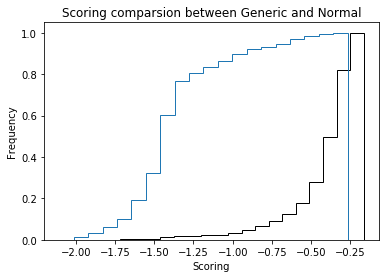

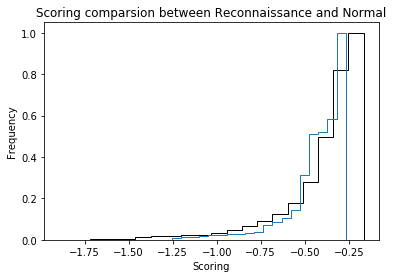

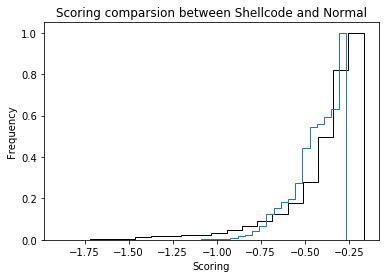

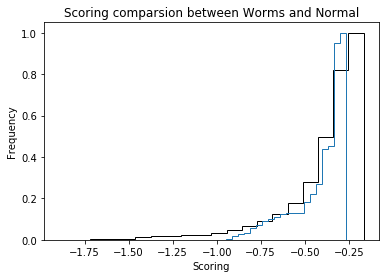

In [24]:
drawSingle('Normal')
drawComparison('Normal', 'Fuzzers')
drawComparison('Normal', 'Analysis')
drawComparison('Normal', 'Backdoor')
drawComparison('Normal', 'DoS')
drawComparison('Normal', 'Exploits')
drawComparison('Normal', 'Generic')
drawComparison('Normal', 'Reconnaissance')
drawComparison('Normal', 'Shellcode')
drawComparison('Normal', 'Worms')


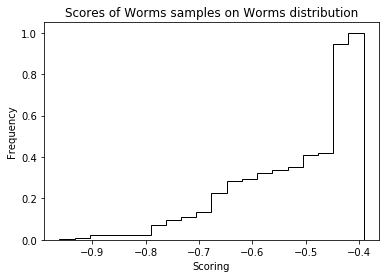

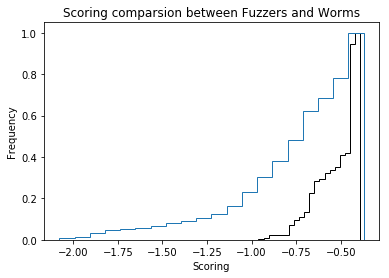

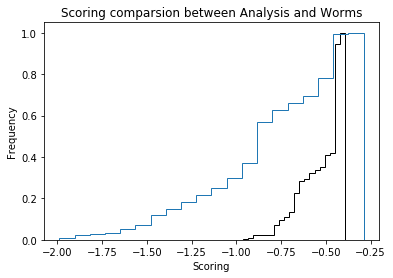

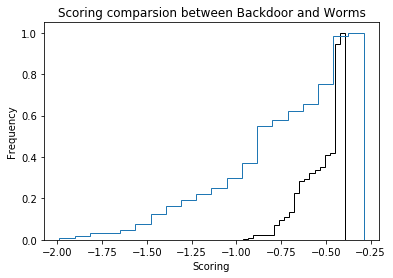

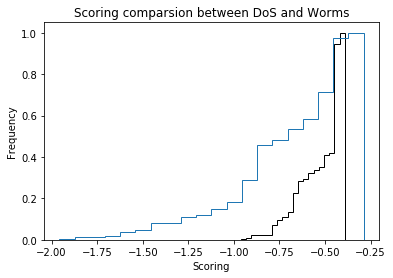

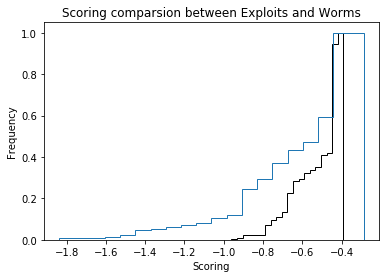

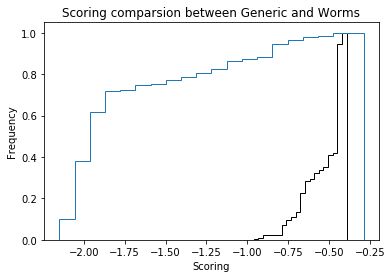

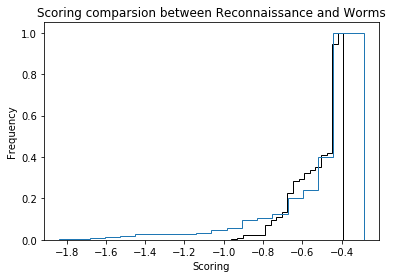

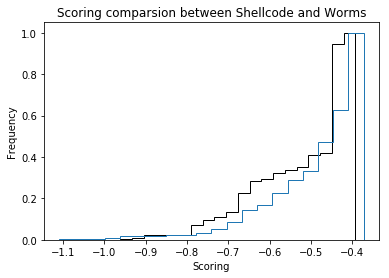

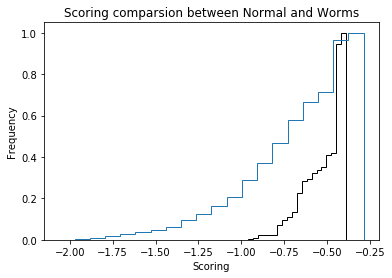

In [25]:
drawSingle('Worms')
drawComparison('Worms', 'Fuzzers')
drawComparison('Worms', 'Analysis')
drawComparison('Worms', 'Backdoor')
drawComparison('Worms', 'DoS')
drawComparison('Worms', 'Exploits')
drawComparison('Worms', 'Generic')
drawComparison('Worms', 'Reconnaissance')
drawComparison('Worms', 'Shellcode')
drawComparison('Worms', 'Normal')